In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image, ImageChops
from sklearn.neighbors import KernelDensity
import random

In [3]:
pip install piexif

In [4]:
import piexif

path1_1='/content/drive/MyDrive/mj_train/train_down/'
path1_2='/content/drive/MyDrive/mj_train/train_front/'
path1_3='/content/drive/MyDrive/mj_train/train_up/'
path2_1='/content/drive/MyDrive/mj_test/test_down/'
path2_2='/content/drive/MyDrive/mj_test/test_front/'
path2_3='/content/drive/MyDrive/mj_test/test_up/'
path3='/content/drive/MyDrive/coco_anomly/coco/'

In [5]:
# 이미지의 손상된 정보를 삭제하는 과정
for i in range(len(os.listdir(path1_1))):
  piexif.remove(path1_1 + os.listdir(path1_1)[i])

for i in range(len(os.listdir(path1_2))):
  piexif.remove(path1_2 + os.listdir(path1_2)[i])

for i in range(len(os.listdir(path1_3))):
  piexif.remove(path1_3 + os.listdir(path1_3)[i])

In [6]:
for i in range(0,len(os.listdir(path2_1)),1):
  piexif.remove(path2_1 + os.listdir(path2_1)[i])

for i in range(0,len(os.listdir(path2_2)),1):
  piexif.remove(path2_2 + os.listdir(path2_2)[i])

for i in range(0,len(os.listdir(path2_3)),1):
  piexif.remove(path2_3 + os.listdir(path2_3)[i])

In [7]:
for i in range(0,len(os.listdir(path3)),1):
  piexif.remove(path3 + os.listdir(path3)[i])

In [8]:
% matplotlib inline

In [9]:
# training, validation, anomaly data로 분리. ( anomaly data : coco data 96. )
# Image resizing

batch_size = 10
targetsize=(240,240)
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/mj_train',
    target_size=targetsize,
    batch_size=batch_size,
    class_mode='input'
    )

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/mj_test',
    target_size=targetsize,
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/coco_anomly',
    target_size=targetsize,
    batch_size=batch_size,
    class_mode='input'
    )

Found 187 images belonging to 3 classes.
Found 187 images belonging to 3 classes.
Found 96 images belonging to 1 classes.


In [10]:
# Autoencoder model
# 320, 160으로 2-layer로 만든 model

inputshape=(240,240,3)
model = Sequential()

# size 줄이기.
model.add(Conv2D(320, (3, 3), padding='same',activation='relu', input_shape=inputshape))
model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 

model.add(Conv2D(160,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same')) 

# size 다시 복원.
model.add(Conv2D(160,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(320,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))


model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))


model.summary()

# Model compile 
opt=keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=opt, loss='mean_squared_error') # MSE 사용

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 240, 320)     8960      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 320)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 160)     460960    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 160)       230560    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 120, 120, 160)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 320)     4

In [11]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = '/content/drive/My Drive/model1.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
hist=model.fit_generator(
    train_generator,
    steps_per_epoch=20 // batch_size,
     epochs=300,
     validation_data=validation_generator,
     validation_steps=20 // batch_size,
     shuffle = True,
     callbacks=[es, save_best])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/300
2/2 [==============================] - 1s 685ms/step - loss: 0.0503 - val_loss: 0.0574
Epoch 2/300
2/2 [==============================] - 1s 414ms/step - loss: 0.0445 - val_loss: 0.0340
Epoch 3/300
2/2 [==============================] - 1s 349ms/step - loss: 0.0466 - val_loss: 0.0419
Epoch 4/300
2/2 [==============================] - 1s 379ms/step - loss: 0.0384 - val_loss: 0.0319
Epoch 5/300
2/2 [==============================] - 1s 379ms/step - loss: 0.0294 - val_loss: 0.0275
Epoch 6/300
2/2 [==============================] - 1s 365ms/step - loss: 0.0270 - val_loss: 0.0260
Epoch 7/300
2/2 [==============================] - 1s 397ms/step - loss: 0.0178 - val_loss: 0.0157
Epoch 8/300
2/2 [==============================] - 1s 325ms/step - loss: 0.0187 - val_loss: 0.0174
Epoch 9/300
2/2 [==============================] - 1s 343ms/step - loss: 0.0232 - val_loss: 0.0250
Epoch 10/300
2/2 [===============

In [12]:
model.save('/content/drive/My Drive/model1.h5')

In [13]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model('/content/drive/My Drive/model1.keras')

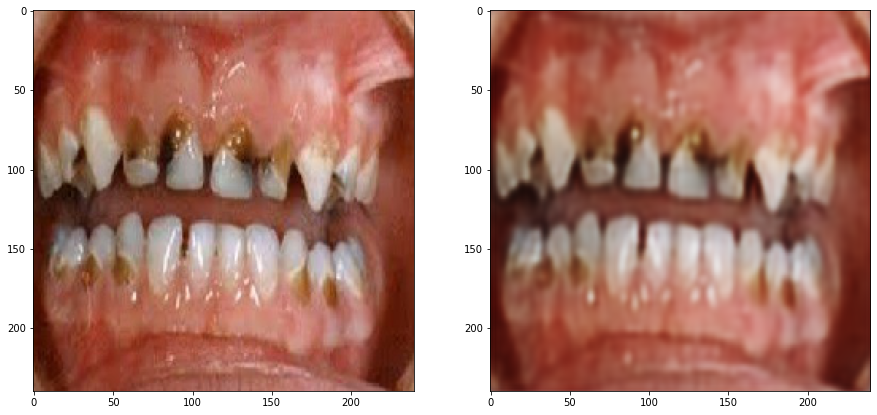

In [14]:
# Test the model by viewing a sample of original and reconstructed images
data_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1

predicted = model.predict(data_list[0])
no_of_samples = 1
_, axs = plt.subplots(no_of_samples, 2, figsize=(15, 24))
axs = axs.flatten()
imgs = []
for i in range(no_of_samples):
    imgs.append(data_list[i][i])
    imgs.append(predicted[i])
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [15]:
# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate_generator(validation_generator)}, error on anomaly set:{model.evaluate_generator(anomaly_generator)}")

Instructions for updating:
Please use Model.evaluate, which supports generators.
Error on validation set:0.0014390177093446255, error on anomaly set:0.00849838461726904


In [16]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 96x96x3 and compresses it down to a 3x3x3 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(320, (3, 3), padding='same',activation='relu', input_shape=(240, 240, 3), weights=model.layers[0].get_weights()) )
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.add(Conv2D(160,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.summary() # 이미지가 들어갔을때 normal인지 anomaly인지 확인하기 위한 과정.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 240, 240, 320)     8960      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 120, 120, 320)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 120, 160)     460960    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 160)       0         
Total params: 469,920
Trainable params: 469,920
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Creating encoded (compressed versions of the training, validation and anomalous images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder
encoded_images = encoder_replica.predict_generator(train_generator)
encoded_images_flat = [np.reshape(img, (576000)) for img in encoded_images]

validation_encoded = encoder_replica.predict_generator(validation_generator)
val_enc_flat = [np.reshape(img, (576000)) for img in validation_encoded]

anom_encoded = encoder_replica.predict_generator(anomaly_generator)
anom_enc_flat = [np.reshape(img, (576000)) for img in anom_encoded]

Instructions for updating:
Please use Model.predict, which supports generators.


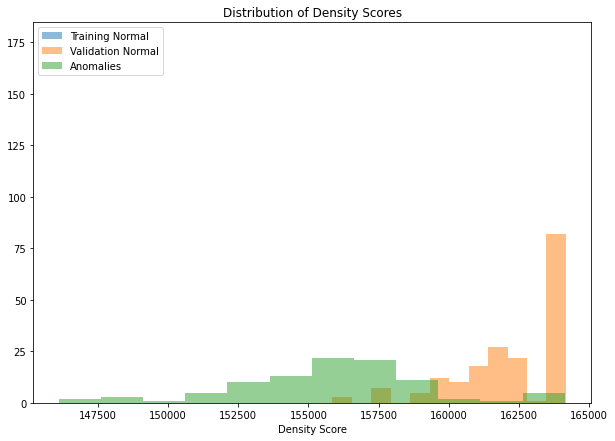

In [18]:
# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(encoded_images_flat)
training_density_scores = kde.score_samples(encoded_images_flat) 
validation_density_scores = kde.score_samples(val_enc_flat)
anomaly_density_scores = kde.score_samples(anom_enc_flat)

# Plotting the density distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(validation_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(anomaly_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper left')
plt.xlabel('Density Score')
plt.show()

In [19]:
# Creat a function that will classify whether an unseen image is normal or an anomaly
# Low density and high reconstruction error mean that the image is likely to be anomalous
def check_anomaly(img_path):
    density_threshold = 0 # This threshold was chosen based on looking at the distribution of the density scores of the normal class (validation set)
    reconstruction_error_threshold = 0.003 # This threshold was chosen based on looking at the distribution of reconstruction errors of the normal class
    img  = Image.open(img_path)
    img = np.array(img.resize((240,240), Image.ANTIALIAS))
    img = img / 255
    encoded_img = encoder_replica.predict(np.array([img])) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (576000)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
#     print(f'density: {density}')
    reconstruction = model.predict(np.array([img]))
    reconstruction_error = model.evaluate(reconstruction,np.array([img]), batch_size = 1)
#     print(f'reconstruction_error: {reconstruction_error}')
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        return True
    else:
        return False 

In [20]:
# Check what proportion of onion images are classified as anomalous
test_files = []
for (dirpath, dirnames, filenames) in os.walk('/content/drive/My Drive/mj_test'):
    for x in filenames:
        if x.endswith(".jpg"):
            test_files.append(os.path.join(dirpath, x))

test_predictions = []
test_normal = []
for file in test_files:
    print(file)
    test_predictions.append(check_anomaly(file))
    if check_anomaly(file)==False:
      test_normal.append(file)


print(sum(test_predictions)/len(test_predictions))

/content/drive/My Drive/mj_test/test_down/6081.jpg
1/1 [==============================] - 0s 11ms/step - loss: 0.0014
/content/drive/My Drive/mj_test/test_down/30478.jpg
1/1 [==============================] - 0s 10ms/step - loss: 0.0051
/content/drive/My Drive/mj_test/test_down/30549.jpg
1/1 [==============================] - 0s 10ms/step - loss: 0.0014
/content/drive/My Drive/mj_test/test_down/30568.jpg
1/1 [==============================] - 0s 10ms/step - loss: 0.0014
/content/drive/My Drive/mj_test/test_down/6084.jpg
1/1 [==============================] - 0s 11ms/step - loss: 0.0054
/content/drive/My Drive/mj_test/test_down/30569.jpg
1/1 [==============================] - 0s 12ms/step - loss: 0.0013
/content/drive/My Drive/mj_test/test_down/3123.jpg
1/1 [==============================] - 0s 11ms/step - loss: 0.0011
/content/drive/My Drive/mj_test/test_down/30184.jpg
1/1 [==============================] - 0s 11ms/step - loss: 0.0012
/content/drive/My Drive/mj_test/test_down/30365.jpg

In [21]:
print(len(test_predictions)-sum(test_predictions)) # Normal 이라고 판단한 data의 갯수

print(test_normal) # test data에서 normal 이라고 판단한 data들의 path
print(len(test_normal)) # test data에서 normal이라고 판단한 data들의 갯수

132
['/content/drive/My Drive/mj_test/test_down/6081.jpg', '/content/drive/My Drive/mj_test/test_down/30549.jpg', '/content/drive/My Drive/mj_test/test_down/30568.jpg', '/content/drive/My Drive/mj_test/test_down/30569.jpg', '/content/drive/My Drive/mj_test/test_down/3123.jpg', '/content/drive/My Drive/mj_test/test_down/30184.jpg', '/content/drive/My Drive/mj_test/test_down/30365.jpg', '/content/drive/My Drive/mj_test/test_down/3128.jpg', '/content/drive/My Drive/mj_test/test_down/3005.jpg', '/content/drive/My Drive/mj_test/test_down/30314.jpg', '/content/drive/My Drive/mj_test/test_down/30182.jpg', '/content/drive/My Drive/mj_test/test_front/3046.jpg', '/content/drive/My Drive/mj_test/test_front/30479.jpg', '/content/drive/My Drive/mj_test/test_front/30481.jpg', '/content/drive/My Drive/mj_test/test_front/30480.jpg', '/content/drive/My Drive/mj_test/test_front/30548.jpg', '/content/drive/My Drive/mj_test/test_front/30463.jpg', '/content/drive/My Drive/mj_test/test_front/30519.jpg', '/c

In [22]:
# Check what proportion of onion images are classified as anomalous
planet_files = []
for (dirpath, dirnames, filenames) in os.walk('/content/drive/MyDrive/coco_anomly'):
    for x in filenames:
        if x.endswith(".jpg"):
            planet_files.append(os.path.join(dirpath, x))

planet_predictions = []
planet_normal = []
for file in planet_files:
    planet_predictions.append(check_anomaly(file))
    if check_anomaly(file)==False:
      planet_normal.append(file)
print(sum(planet_predictions)/len(planet_predictions))

1/1 [==============================] - 0s 11ms/step - loss: 0.0084
0.8958333333333334


In [23]:
print(len(planet_predictions)-sum(planet_predictions)) # Normal 이라고 판단한 data의 갯수

print(planet_normal) # anomaly data에서 normal 이라고 판단한 data들의 path
print(len(planet_normal)) # anomaly data에서 normal이라고 판단한 data들의 갯수

10
['/content/drive/MyDrive/coco_anomly/coco/000000210896.jpg', '/content/drive/MyDrive/coco_anomly/coco/000000210627.jpg', '/content/drive/MyDrive/coco_anomly/coco/000000211264.jpg', '/content/drive/MyDrive/coco_anomly/coco/000000204686.jpg', '/content/drive/MyDrive/coco_anomly/coco/000000206392.jpg', '/content/drive/MyDrive/coco_anomly/coco/000000220201.jpg', '/content/drive/MyDrive/coco_anomly/coco/000000217909.jpg', '/content/drive/MyDrive/coco_anomly/coco/000000217384.jpg', '/content/drive/MyDrive/coco_anomly/coco/000000220324.jpg', '/content/drive/MyDrive/coco_anomly/coco/000000219720.jpg']
10


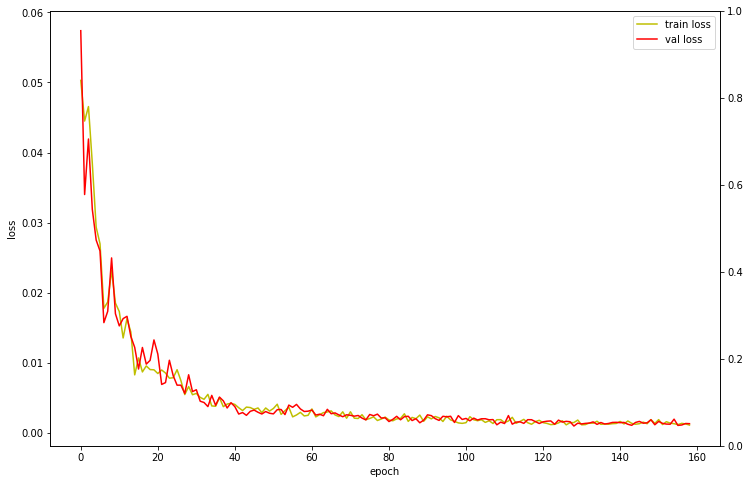

In [24]:
fig, loss_ax = plt.subplots(figsize=(12,8))
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

plt.show()

In [25]:
%tensorflow_version 1.x # 이렇게 적으면, 1.* 버전을 사용할 수 있음.
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
import cv2
import numpy as np
import matplotlib.pylab as plt

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 이렇게 적으면, 1.* 버전을 사용할 수 있음.`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [26]:
# VGG-16 CAM
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

num_classes = 2
model = VGG16(weights='imagenet', include_top=False, pooling = 'avg')
x = Dense(num_classes, activation='softmax', name='predictions')(model.output)

custom_vgg_model = Model(model.input, x)

custom_vgg_model.load_weights('/content/drive/My Drive/transfer_learning_data/vgg16_orthodontics_cam.h5')

class_weights = custom_vgg_model.layers[-1].get_weights()[0]
final_conv_layer = get_output_layer(custom_vgg_model, "block5_pool")
get_output = K.function([custom_vgg_model.layers[0].input], [final_conv_layer.output, custom_vgg_model.layers[-1].output])

Y_label = ['Orthodontics','Normal']

58892288/58889256 [==============================] - 1s 0us/step


In [27]:
normal = test_normal + planet_normal

len(normal)

142

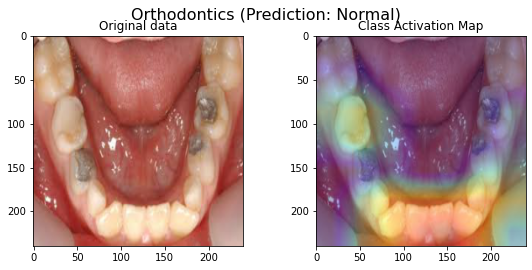

In [28]:
width, height = 240, 240
img_path=normal[1]
original_img = plt.imread(img_path)
original_img = cv2.resize(original_img, (height, width))
img = np.array([original_img])

[conv_outputs, predictions] = get_output([img])

#Create the class activation map.
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
for i, w in enumerate(class_weights[:, 1]):
	cam += w * conv_outputs[0,:, :, i]
#print("predictions", predictions)
cam /= np.max(cam)
cam[cam<0.2] = 0
cam = cv2.resize(cam, (height, width))

if np.argmax(predictions) == 1:
	tit_sup = 'Orthodontics (Prediction: %s)' % Y_label[np.argmax(predictions)]
	tit = 'Orthodontics'
else:
	tit_sup = 'Normal (Prediction: %s)' % Y_label[np.argmax(predictions)]
	tit = 'Normal'

fig=plt.figure(2,figsize=(8,4)) # fig=plt.figure(2,figsize=(4,270))
sp1=plt.subplot(1,2,1)
sp1.imshow(original_img.astype(int))
sp1.set_title("Original data")

# plt.figure(2,figsize=(7,5))
sp2 =plt.subplot(1,2,2)
sp2.imshow(original_img.astype(int))
sp2.imshow(cam, alpha=0.3, cmap='jet')
sp2.set_title("Class Activation Map")

sup_title=fig.suptitle(tit_sup, fontsize=16, y=0.93)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.subplots_adjust(top=0.83)

In [29]:
width, height = 240, 240

for k in range(len(normal)):
  img_path=normal[k]
  original_img = plt.imread(img_path)
  original_img = cv2.resize(original_img, (height, width))
  img = np.array([original_img])

  [conv_outputs, predictions] = get_output([img])

  #Create the class activation map.
  cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
  for i, w in enumerate(class_weights[:, 1]):
  	cam += w * conv_outputs[0,:, :, i]
  #print("predictions", predictions)
  cam /= np.max(cam)
  cam[cam<0.2] = 0
  cam = cv2.resize(cam, (height, width))

  if np.argmax(predictions) == 1:
  	tit_sup = 'Prediction: %s' % Y_label[np.argmax(predictions)]
  else:
  	tit_sup = '(Prediction: %s' % Y_label[np.argmax(predictions)]

  fig=plt.figure(2,figsize=(8, len(normal)*4))
  sp1=plt.subplot(len(normal), 2, 2*k+1)
  sp1.imshow(original_img.astype(int))
  sp1.set_title("Original data")

  sp2 =plt.subplot(len(normal), 2, 2*k+2)
  sp2.imshow(original_img.astype(int))
  sp2.imshow(cam, alpha=0.3, cmap='jet')
  sp2.set_title(tit_sup)

  plt.tight_layout(rect=[0, 0.03, 1, 0.98])

Output hidden; open in https://colab.research.google.com to view.